# Rossmann Sales

## 0) Setup and Data Loading

In [46]:
# 0.1 Imports
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 0.2 Global settings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

# 0.3 Dataset paths
DATA_DIR = Path(r"C:\bootcamp\Rossman_finalproject\Datasets")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
STORE_PATH = DATA_DIR / "store.csv"

# 0.4 Load raw datasets
train_raw = pd.read_csv(TRAIN_PATH, low_memory=False)
test_raw = pd.read_csv(TEST_PATH, low_memory=False)
store = pd.read_csv(STORE_PATH, low_memory=False)



## 1) Data Overview

In [ ]:
# 1.1 Column types: train and store
print('train_raw column types:')
display(train_raw.dtypes.rename('dtype').reset_index().rename(columns={'index': 'column'}))

print('store column types:')
display(store.dtypes.rename('dtype').reset_index().rename(columns={'index': 'column'}))

train_raw column types:


,column,dtype
0,Store,int64
1,DayOfWeek,int64
2,Date,object
3,Sales,int64
4,Customers,int64
5,Open,int64
6,Promo,int64
7,StateHoliday,object
8,SchoolHoliday,int64


store column types:


,column,dtype
0,Store,int64
1,StoreType,object
2,Assortment,object
3,CompetitionDistance,float64
4,CompetitionOpenSinceMonth,float64
5,CompetitionOpenSinceYear,float64
6,Promo2,int64
7,Promo2SinceWeek,float64
8,Promo2SinceYear,float64
9,PromoInterval,object


In [ ]:
# 1.2 date columns
train_raw['Date'] = pd.to_datetime(train_raw['Date'])
test_raw['Date'] = pd.to_datetime(test_raw['Date'])

# 1.3 shape
print('train_raw:', train_raw.shape)
print('test_raw :', test_raw.shape)
print('store    :', store.shape)

train_raw: (1017209, 9)
test_raw : (41088, 8)
store    : (1115, 10)


In [ ]:
# 1.4 Preview training dataset
display(train_raw.head())

# 1.5 Dataset size summary
overview = pd.DataFrame({
    'rows': [len(train_raw), len(test_raw), len(store)],
    'cols': [train_raw.shape[1], test_raw.shape[1], store.shape[1]],
}, index=['train_raw', 'test_raw', 'store'])
display(overview)

# 1.6 Missing-value  (train)
train_nan = pd.DataFrame({
    'NaN_Count': train_raw.isna().sum(),
    'NaN_Pct': (train_raw.isna().sum() / len(train_raw) * 100).round(2)
}).sort_values('NaN_Count', ascending=False)

# 1.7 Missing-value  (store)
store_nan = pd.DataFrame({
    'NaN_Count': store.isna().sum(),
    'NaN_Pct': (store.isna().sum() / len(store) * 100).round(2)
}).sort_values('NaN_Count', ascending=False)

# 1.8 Display NaN
print('Train NaN columns:')
display(train_nan[train_nan['NaN_Count'] > 0])
print('Store NaN columns:')
display(store_nan[store_nan['NaN_Count'] > 0])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,rows,cols
train_raw,1017209,9
test_raw,41088,8
store,1115,10


Train NaN columns:


,NaN_Count,NaN_Pct


Store NaN columns:


,NaN_Count,NaN_Pct
PromoInterval,544,48.79
Promo2SinceYear,544,48.79
Promo2SinceWeek,544,48.79
CompetitionOpenSinceYear,354,31.75
CompetitionOpenSinceMonth,354,31.75
CompetitionDistance,3,0.27


## 2) Exploratory Data Analysis (Insights + Graphics)

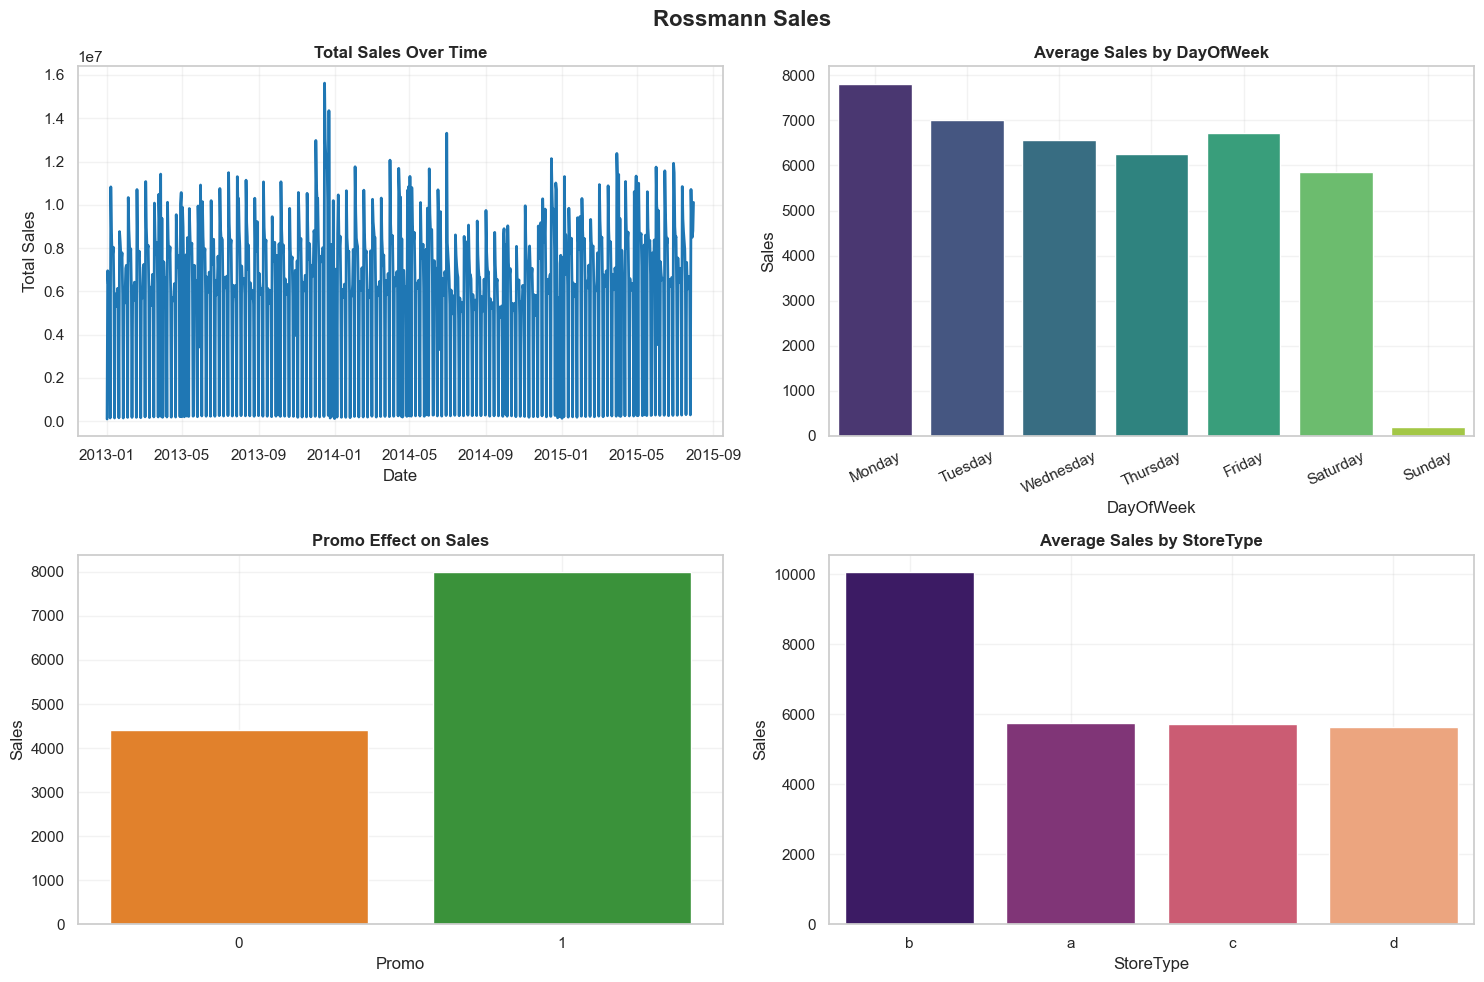

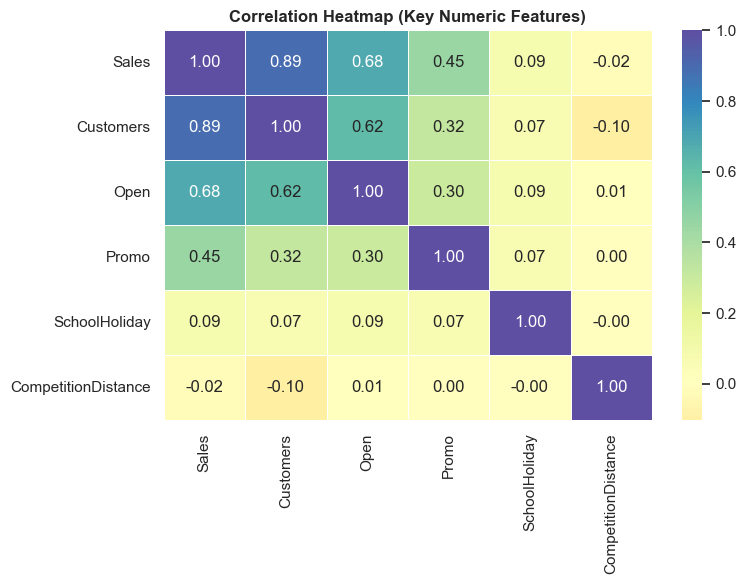

In [ ]:
# 2.1 Merge train with store
train_eda = train_raw.merge(store, on='Store', how='left')

# 2.2 Daily total sales trend
sales_daily = train_eda.groupby('Date', as_index=False)['Sales'].sum()

# 2.3 business insight 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Rossmann Sales', fontsize=16, fontweight='bold')

# Trend over time
sns.lineplot(data=sales_daily, x='Date', y='Sales', color='#1f77b4', linewidth=2, ax=axes[0, 0])
axes[0, 0].set_title('Total Sales Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')

# Day of week
dow_avg = train_eda.groupby('DayOfWeek', as_index=False)['Sales'].mean()
dow_order = [1, 2, 3, 4, 5, 6, 7]
dow_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg['DayName'] = pd.Categorical(
    dow_avg['DayOfWeek'].map(dict(zip(dow_order, dow_labels))),
    categories=dow_labels,
    ordered=True,
)
dow_avg = dow_avg.sort_values('DayName')
sns.barplot(data=dow_avg, x='DayName', y='Sales', palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Average Sales by DayOfWeek', fontweight='bold')
axes[0, 1].set_xlabel('DayOfWeek')
axes[0, 1].tick_params(axis='x', rotation=25)

# Promo
promo_avg = train_eda.groupby('Promo', as_index=False)['Sales'].mean()
sns.barplot(data=promo_avg, x='Promo', y='Sales', palette=['#ff7f0e', '#2ca02c'], ax=axes[1, 0])
axes[1, 0].set_title('Promo Effect on Sales', fontweight='bold')

# Store type
storetype_avg = train_eda.groupby('StoreType', as_index=False)['Sales'].mean().sort_values('Sales', ascending=False)
sns.barplot(data=storetype_avg, x='StoreType', y='Sales', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Average Sales by StoreType', fontweight='bold')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

# 2.4 Correlation on key numeric columns
corr_cols = ['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance']
corr_df = train_eda[corr_cols].copy()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df.corr(numeric_only=True),
    annot=True,
    fmt='.2f',
    cmap='Spectral',
    center=0,
    linewidths=0.5,
)
plt.title('Correlation Heatmap (Key Numeric Features)', fontweight='bold')
plt.tight_layout()
plt.show()

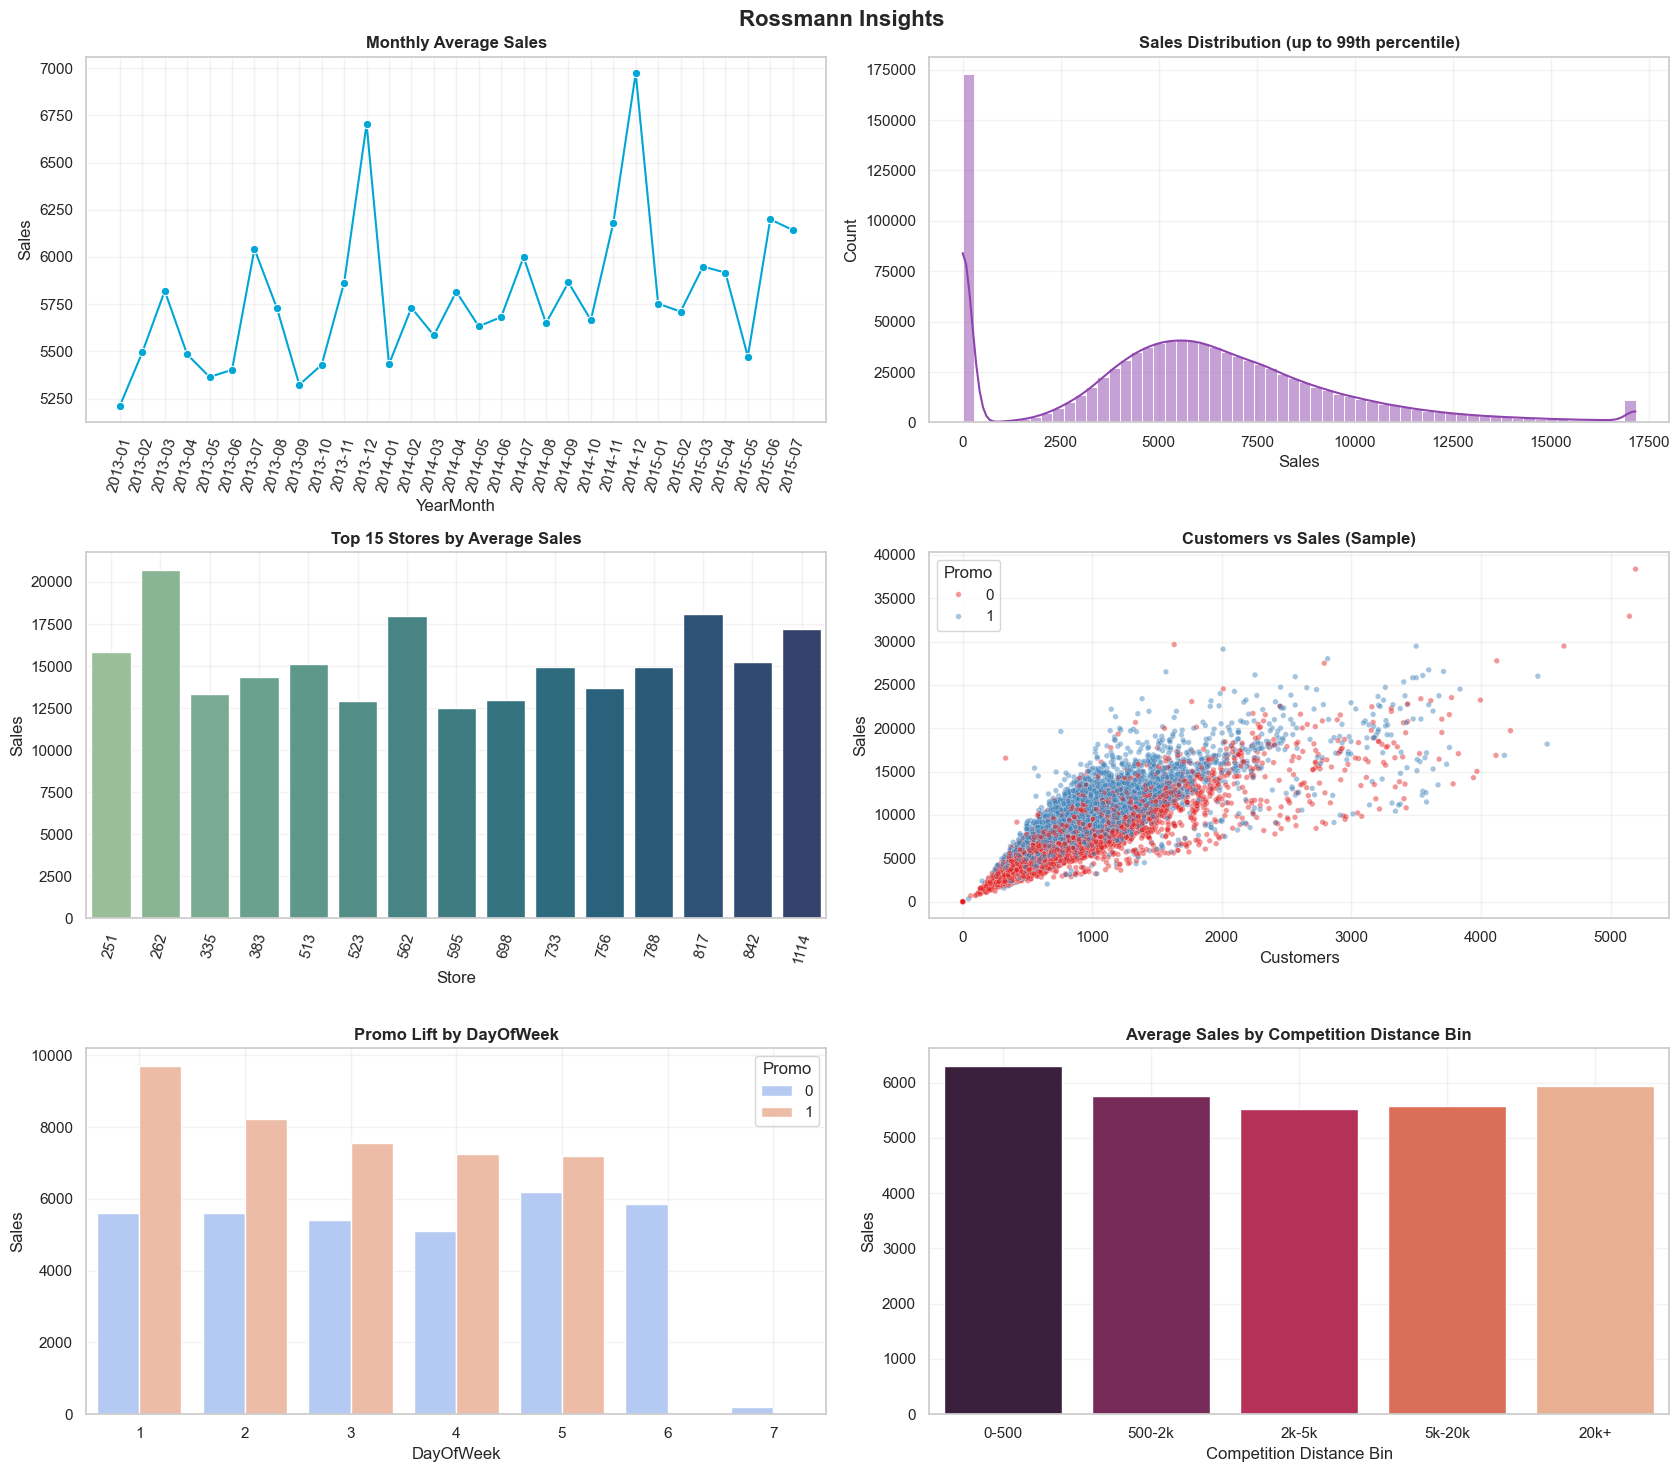

In [ ]:
eda = train_eda.copy()
eda['YearMonth'] = eda['Date'].dt.to_period('M').astype(str)

# Monthly average sales
monthly_sales = eda.groupby('YearMonth', as_index=False)['Sales'].mean()

# Sales distribution 
sales_cap = eda['Sales'].clip(upper=eda['Sales'].quantile(0.99))

# Top stores by average sales
top_store_sales = (
    eda.groupby('Store', as_index=False)['Sales']
    .mean()
    .sort_values('Sales', ascending=False)
    .head(15)
)

# Customers vs Sales sample 
scatter_sample = eda[['Customers', 'Sales', 'Promo']].dropna().sample(n=min(30000, len(eda)), random_state=42)

# Promo uplift by day of week
promo_dow = eda.groupby(['DayOfWeek', 'Promo'], as_index=False)['Sales'].mean()

# Competition distance 
eda['CompDistBin'] = pd.cut(
    eda['CompetitionDistance'],
    bins=[0, 500, 2000, 5000, 20000, np.inf],
    labels=['0-500', '500-2k', '2k-5k', '5k-20k', '20k+']
)
comp_bin_sales = eda.groupby('CompDistBin', as_index=False)['Sales'].mean()

fig, axes = plt.subplots(3, 2, figsize=(17, 15))
fig.suptitle('Rossmann Insights', fontsize=16, fontweight='bold')

sns.lineplot(data=monthly_sales, x='YearMonth', y='Sales', marker='o', color='#00a6d6', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Average Sales', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=75)

sns.histplot(sales_cap, bins=60, kde=True, color='#8e44ad', ax=axes[0, 1])
axes[0, 1].set_title('Sales Distribution (up to 99th percentile)', fontweight='bold')
axes[0, 1].set_xlabel('Sales')

sns.barplot(data=top_store_sales, x='Store', y='Sales', palette='crest', ax=axes[1, 0])
axes[1, 0].set_title('Top 15 Stores by Average Sales', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=75)

sns.scatterplot(data=scatter_sample, x='Customers', y='Sales', hue='Promo', palette='Set1', alpha=0.45, s=16, ax=axes[1, 1])
axes[1, 1].set_title('Customers vs Sales (Sample)', fontweight='bold')

sns.barplot(data=promo_dow, x='DayOfWeek', y='Sales', hue='Promo', palette='coolwarm', ax=axes[2, 0])
axes[2, 0].set_title('Promo Lift by DayOfWeek', fontweight='bold')

sns.barplot(data=comp_bin_sales, x='CompDistBin', y='Sales', palette='rocket', ax=axes[2, 1])
axes[2, 1].set_title('Average Sales by Competition Distance Bin', fontweight='bold')
axes[2, 1].set_xlabel('Competition Distance Bin')

for ax in axes.flat:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

## 3) Data Engineering + Feature Engineering

In [ ]:
# 3.1 feature-engineering
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # 3.1.1 Work on a copy
    d = df.copy()

    # 3.1.2 Date-based time features
    d['Date'] = pd.to_datetime(d['Date'])
    d['Year'] = d['Date'].dt.year
    d['Month'] = d['Date'].dt.month
    d['Day'] = d['Date'].dt.day
    d['WeekOfYear'] = d['Date'].dt.isocalendar().week.astype(int)
    d['DayOfYear'] = d['Date'].dt.dayofyear
    d['IsMonthStart'] = d['Date'].dt.is_month_start.astype(int)
    d['IsMonthEnd'] = d['Date'].dt.is_month_end.astype(int)
    d['IsWeekend'] = d['DayOfWeek'].isin([6, 7]).astype(int)

    # 3.1.3 Competition time features
    comp_date = pd.to_datetime(
        dict(
            year=d['CompetitionOpenSinceYear'].fillna(1900).astype(int),
            month=d['CompetitionOpenSinceMonth'].fillna(1).astype(int),
            day=1,
        ),
        errors='coerce'
    )
    d['CompMonthsSinceOpen'] = (
        (d['Date'].dt.year - comp_date.dt.year) * 12 + (d['Date'].dt.month - comp_date.dt.month)
    ).astype(float)
    d['CompMonthsSinceOpen'] = d['CompMonthsSinceOpen'].clip(lower=0)
    d['CompetitionActive'] = (d['CompMonthsSinceOpen'] > 0).astype(int)

    # 3.1.4 Promo2 time features
    promo2_start = pd.to_datetime(
        d['Promo2SinceYear'].fillna(1900).astype(int).astype(str)
        + '-W' + d['Promo2SinceWeek'].fillna(1).astype(int).astype(str)
        + '-1',
        format='%G-W%V-%u',
        errors='coerce'
    )
    d['Promo2WeeksSinceStart'] = ((d['Date'] - promo2_start).dt.days / 7.0).astype(float)
    d['Promo2WeeksSinceStart'] = d['Promo2WeeksSinceStart'].clip(lower=0).fillna(0)

    # 3.1.5 Ensure holiday categorical
    d['StateHoliday'] = d['StateHoliday'].astype(str)

    return d

# 3.2 Merge base datasets
train_fe = train_raw.merge(store, on='Store', how='left')
test_fe = test_raw.merge(store, on='Store', how='left')

# 3.3 Apply engineered features
train_fe = add_features(train_fe)
test_fe = add_features(test_fe)

# 3.4 Keep only open stores and positive sales for training
train_fe = train_fe[(train_fe['Open'] == 1) & (train_fe['Sales'] > 0)].copy()

# 3.5 Shape check
print('train_fe shape:', train_fe.shape)
print('test_fe shape :', test_fe.shape)

train_fe shape: (844338, 29)
test_fe shape : (41088, 28)


In [ ]:
# 3.1-Legacy advanced features
from scipy.stats import skew, kurtosis
from sklearn.linear_model import Ridge


# 3.1.2 Harmonic mean helper for positive sales
def harmonic_mean(x):
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return len(x) / np.sum(1.0 / x)


# 3.1.3 Compute historical stats
def compute_recent_stats(history, prefix):
    arr = history.values
    if len(arr) == 0:
        return {
            f"{prefix}_mean": np.nan,
            f"{prefix}_median": np.nan,
            f"{prefix}_hmean": np.nan,
            f"{prefix}_std": np.nan,
            f"{prefix}_skew": np.nan,
            f"{prefix}_kurt": np.nan,
            f"{prefix}_p10": np.nan,
            f"{prefix}_p90": np.nan,
        }

    return {
        f"{prefix}_mean": np.mean(arr),
        f"{prefix}_median": np.median(arr),
        f"{prefix}_hmean": harmonic_mean(arr),
        f"{prefix}_std": np.std(arr),
        f"{prefix}_skew": skew(arr) if len(arr) > 2 else 0,
        f"{prefix}_kurt": kurtosis(arr) if len(arr) > 3 else 0,
        f"{prefix}_p10": np.percentile(arr, 10),
        f"{prefix}_p90": np.percentile(arr, 90),
    }


# 3.1.3 Build historical feature by store and context
def build_recent_features(train_df, target_df, windows_days=[90, 180, 365, 730]):
    train_df = train_df.copy()
    target_df = target_df.copy()
    features = []

    for _, row in target_df.iterrows():
        store_id = row['Store']
        date = row['Date']
        store_hist = train_df[(train_df['Store'] == store_id) & (train_df['Date'] < date)]

        row_feats = {}
        for w in windows_days:
            start_date = date - pd.Timedelta(days=w)
            hist_window = store_hist[store_hist['Date'] >= start_date]

            row_feats.update(compute_recent_stats(hist_window['Sales'], f'hist_{w}d'))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['DayOfWeek'] == row['DayOfWeek']]['Sales'],
                f'dow_{w}d'
            ))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['Promo'] == row['Promo']]['Sales'],
                f'promo_{w}d'
            ))
            row_feats.update(compute_recent_stats(
                hist_window[hist_window['StateHoliday'] == row['StateHoliday']]['Sales'],
                f'holiday_{w}d'
            ))

        features.append(row_feats)

    feat_df = pd.DataFrame(features, index=target_df.index)
    return pd.concat([target_df, feat_df], axis=1)


# 3.1.4 Build store-level trend signal
def build_trend_features(train_df, target_df, lookback_days=365):
    train_df = train_df.copy()
    target_df = target_df.copy()
    trend_preds = []

    for _, row in target_df.iterrows():
        store_id = row['Store']
        date = row['Date']

        store_hist = train_df[(train_df['Store'] == store_id) & (train_df['Date'] < date)]
        store_hist = store_hist[store_hist['Date'] >= date - pd.Timedelta(days=lookback_days)]

        if len(store_hist) < 50:
            trend_preds.append(np.nan)
            continue

        trend_X = pd.get_dummies(
            store_hist[['DayOfYear', 'Promo', 'DayOfWeek']],
            columns=['DayOfWeek'],
            drop_first=True
        )
        trend_y = np.log1p(store_hist['Sales'].values)

        trend_model = Ridge(alpha=1.0)
        trend_model.fit(trend_X, trend_y)

        X_pred = pd.get_dummies(pd.DataFrame([{
            'DayOfYear': row['DayOfYear'],
            'Promo': row['Promo'],
            'DayOfWeek': row['DayOfWeek']
        }]), columns=['DayOfWeek'], drop_first=True)

        X_pred = X_pred.reindex(columns=trend_X.columns, fill_value=0)
        trend_preds.append(trend_model.predict(X_pred)[0])

    target_df['TrendLogSales_1y'] = trend_preds
    return target_df


## 3.1) Graphs

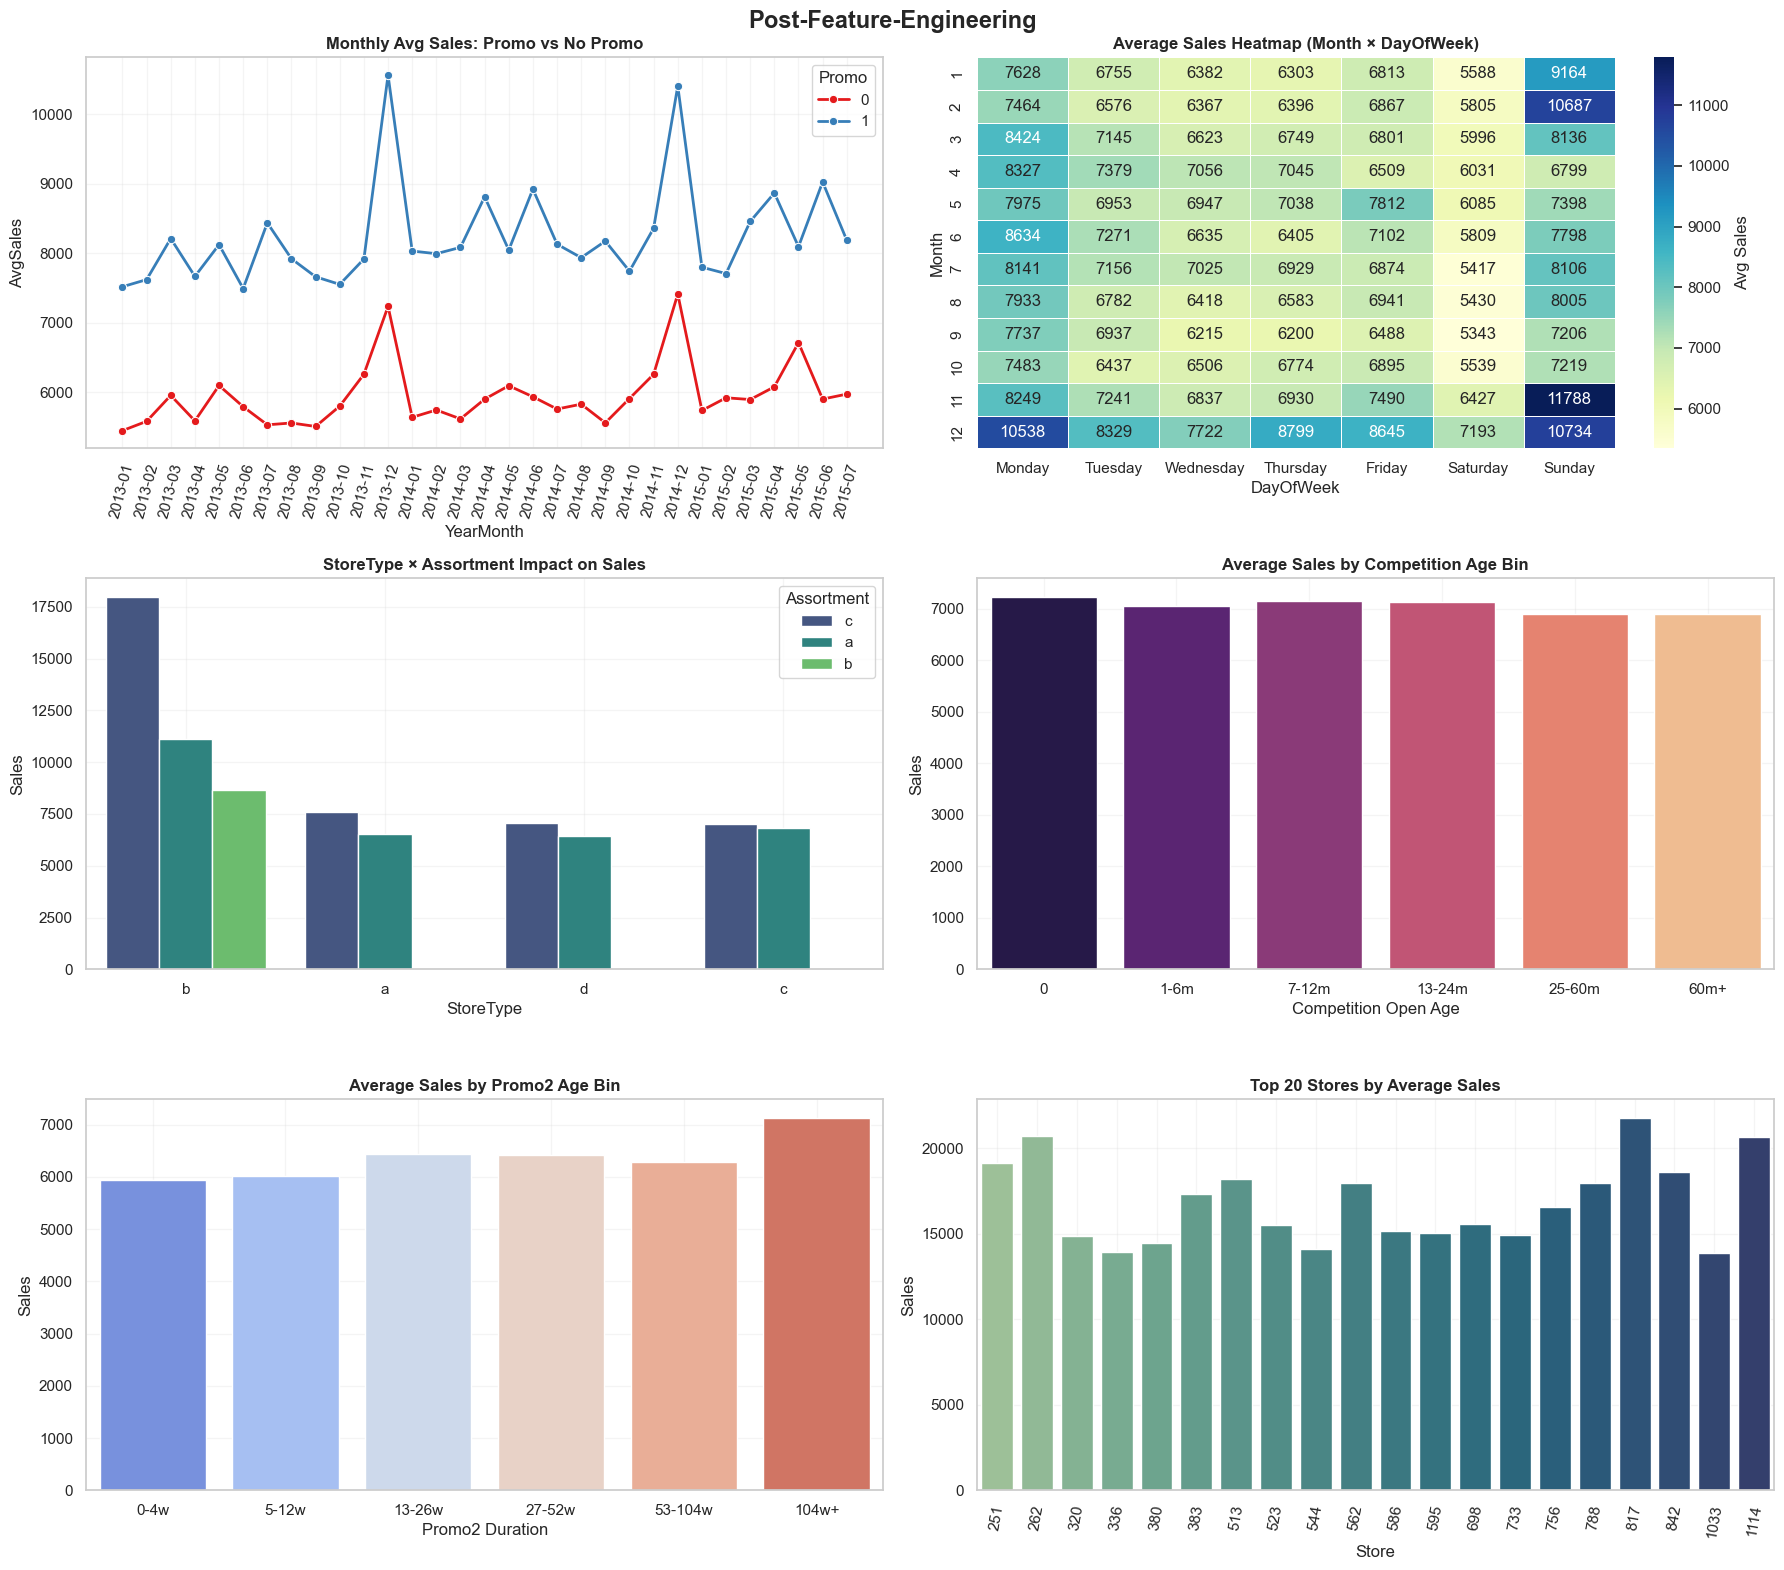

In [ ]:
# 3.2 Post-feature-engineering insights (save copy)
vis = train_fe.copy()

# Keep only open stores with valid sales for cleaner patterns
vis = vis[(vis['Open'] == 1) & (vis['Sales'] > 0)].copy()

# Time keys for grouped analysis
vis['YearMonth'] = vis['Date'].dt.to_period('M').astype(str)

# Aggregations for plots
monthly_promo = (
    vis.groupby(['YearMonth', 'Promo'], as_index=False)['Sales']
    .mean()
    .rename(columns={'Sales': 'AvgSales'})
)

month_dow = vis.groupby(['Month', 'DayOfWeek'], as_index=False)['Sales'].mean()
dow_order = [1, 2, 3, 4, 5, 6, 7]
dow_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_dow_pivot = month_dow.pivot(index='Month', columns='DayOfWeek', values='Sales').reindex(columns=dow_order)
month_dow_pivot.columns = dow_labels

storetype_assort = (
    vis.groupby(['StoreType', 'Assortment'], as_index=False)['Sales']
    .mean()
    .sort_values('Sales', ascending=False)
)

if 'CompMonthsSinceOpen' in vis.columns:
    vis['CompAgeBin'] = pd.cut(
        vis['CompMonthsSinceOpen'],
        bins=[-1, 0, 6, 12, 24, 60, np.inf],
        labels=['0', '1-6m', '7-12m', '13-24m', '25-60m', '60m+']
    )
else:
    vis['CompAgeBin'] = pd.Series(index=vis.index, dtype='object')

comp_age_sales = vis.groupby('CompAgeBin', as_index=False)['Sales'].mean()

if 'Promo2WeeksSinceStart' in vis.columns:
    promo2_nonzero = vis[vis['Promo2WeeksSinceStart'] > 0].copy()
    if len(promo2_nonzero) > 0:
        promo2_nonzero['Promo2AgeBin'] = pd.cut(
            promo2_nonzero['Promo2WeeksSinceStart'],
            bins=[0, 4, 12, 26, 52, 104, np.inf],
            labels=['0-4w', '5-12w', '13-26w', '27-52w', '53-104w', '104w+']
        )
        promo2_age_sales = promo2_nonzero.groupby('Promo2AgeBin', as_index=False)['Sales'].mean()
    else:
        promo2_age_sales = pd.DataFrame({'Promo2AgeBin': [], 'Sales': []})
else:
    promo2_age_sales = pd.DataFrame({'Promo2AgeBin': [], 'Sales': []})

top_stores = (
    vis.groupby('Store', as_index=False)['Sales']
    .mean()
    .sort_values('Sales', ascending=False)
    .head(20)
)

# Figure layout
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('Post-Feature-Engineering', fontsize=17, fontweight='bold')

# 1) Promo vs no-promo monthly trend
sns.lineplot(
    data=monthly_promo, x='YearMonth', y='AvgSales', hue='Promo',
    marker='o', linewidth=2, palette='Set1', ax=axes[0, 0]
 )
axes[0, 0].set_title('Monthly Avg Sales: Promo vs No Promo', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=75)

# 2) Calendar interaction heatmap
sns.heatmap(
    month_dow_pivot, annot=True, fmt='.0f', cmap='YlGnBu',
    linewidths=0.4, cbar_kws={'label': 'Avg Sales'}, ax=axes[0, 1]
 )
axes[0, 1].set_title('Average Sales Heatmap (Month × DayOfWeek)', fontweight='bold')
axes[0, 1].set_xlabel('DayOfWeek')
axes[0, 1].set_ylabel('Month')

# 3) StoreType + Assortment interaction
sns.barplot(
    data=storetype_assort, x='StoreType', y='Sales', hue='Assortment',
    palette='viridis', ax=axes[1, 0]
 )
axes[1, 0].set_title('StoreType × Assortment Impact on Sales', fontweight='bold')

# 4) Competition age effect
sns.barplot(data=comp_age_sales, x='CompAgeBin', y='Sales', palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Average Sales by Competition Age Bin', fontweight='bold')
axes[1, 1].set_xlabel('Competition Open Age')

# 5) Promo2 age effect
if len(promo2_age_sales) > 0:
    sns.barplot(data=promo2_age_sales, x='Promo2AgeBin', y='Sales', palette='coolwarm', ax=axes[2, 0])
    axes[2, 0].set_title('Average Sales by Promo2 Age Bin', fontweight='bold')
    axes[2, 0].set_xlabel('Promo2 Duration')
else:
    axes[2, 0].text(0.5, 0.5, 'No Promo2 active history available', ha='center', va='center')
    axes[2, 0].set_title('Average Sales by Promo2 Age Bin', fontweight='bold')
    axes[2, 0].set_axis_off()

# 6) Top stores performance spread
sns.barplot(data=top_stores, x='Store', y='Sales', palette='crest', ax=axes[2, 1])
axes[2, 1].set_title('Top 20 Stores by Average Sales', fontweight='bold')
axes[2, 1].tick_params(axis='x', rotation=80)

for ax in axes.flat:
    if ax.has_data():
        ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()

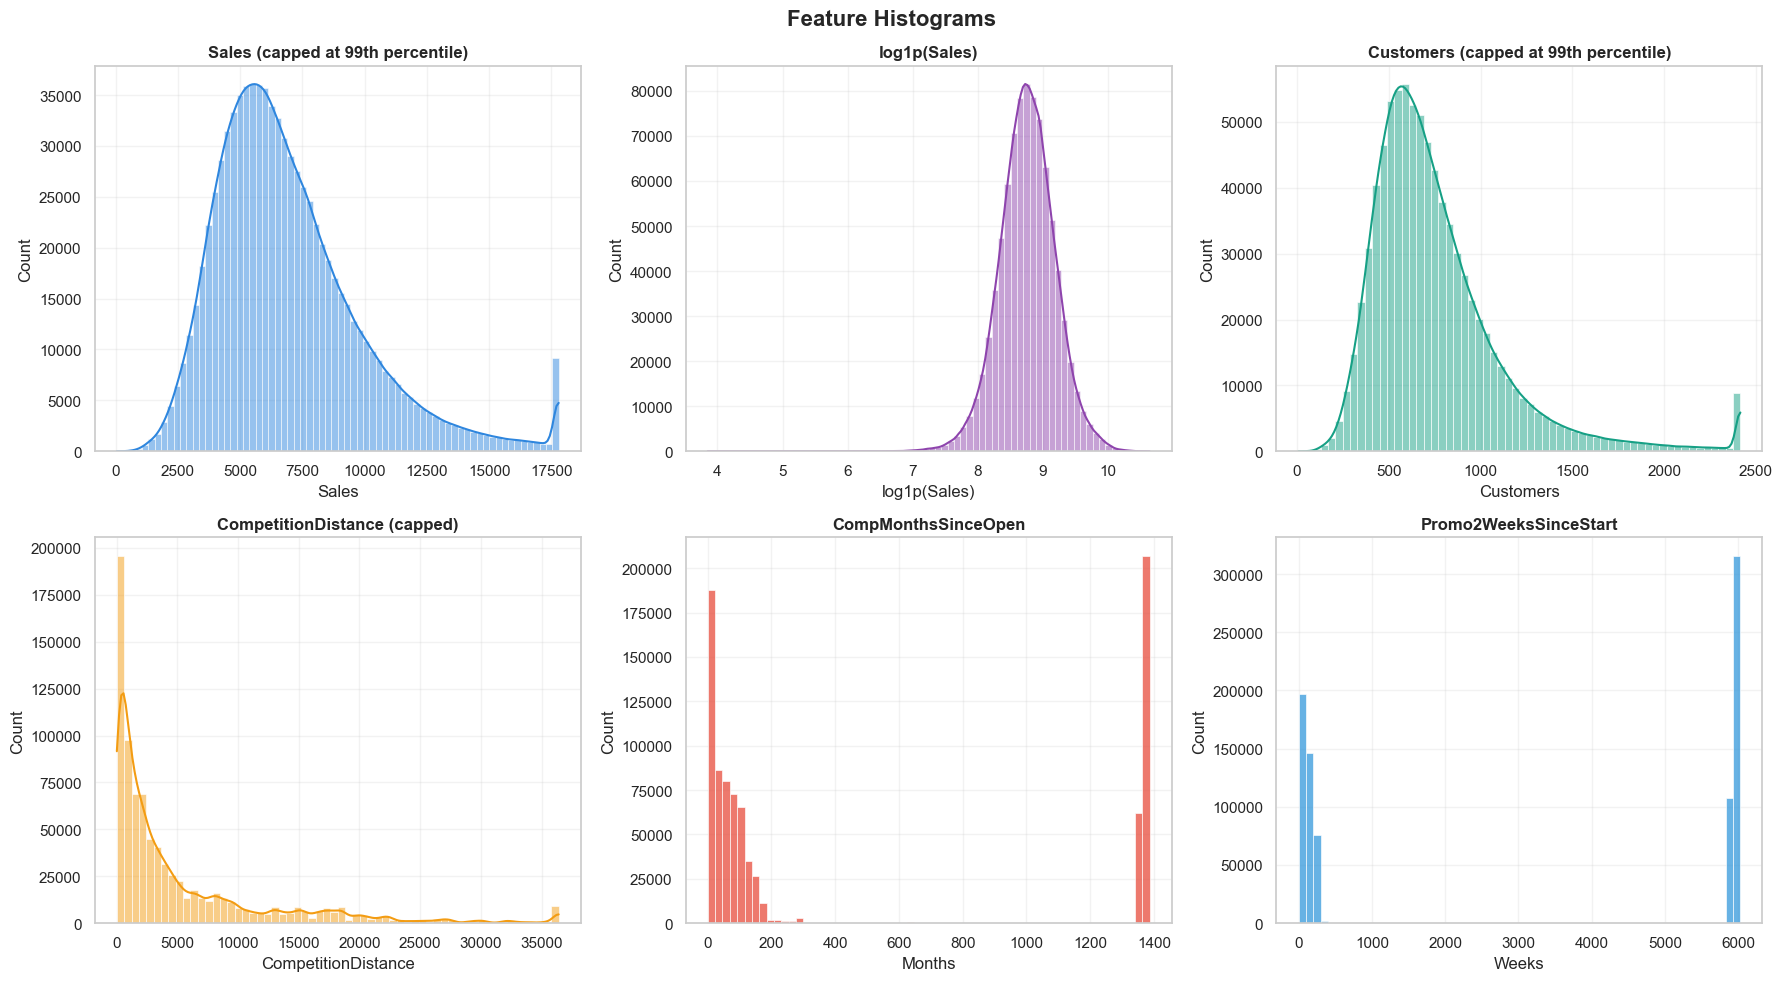

In [ ]:
# 3.7 Histograms (copy)
hist_df = train_fe.copy()

# distributions
hist_df = hist_df[(hist_df['Open'] == 1) & (hist_df['Sales'] > 0)].copy()

# 3.8 Reduce outlier
hist_df['Sales_cap'] = hist_df['Sales'].clip(upper=hist_df['Sales'].quantile(0.99))
if 'Customers' in hist_df.columns:
    hist_df['Customers_cap'] = hist_df['Customers'].clip(upper=hist_df['Customers'].quantile(0.99))
if 'CompetitionDistance' in hist_df.columns:
    hist_df['CompetitionDistance_cap'] = hist_df['CompetitionDistance'].clip(upper=hist_df['CompetitionDistance'].quantile(0.99))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Histograms', fontsize=16, fontweight='bold')

# 3.8.1 Sales distribution
sns.histplot(hist_df['Sales_cap'], bins=70, kde=True, color='#2E86DE', ax=axes[0, 0])
axes[0, 0].set_title('Sales (capped at 99th percentile)', fontweight='bold')
axes[0, 0].set_xlabel('Sales')

# 3.8.2 Log-sales distribution
sns.histplot(np.log1p(hist_df['Sales']), bins=70, kde=True, color='#8E44AD', ax=axes[0, 1])
axes[0, 1].set_title('log1p(Sales)', fontweight='bold')
axes[0, 1].set_xlabel('log1p(Sales)')

# 3.8.3 Customers distribution
if 'Customers_cap' in hist_df.columns:
    sns.histplot(hist_df['Customers_cap'], bins=60, kde=True, color='#16A085', ax=axes[0, 2])
    axes[0, 2].set_title('Customers (capped at 99th percentile)', fontweight='bold')
    axes[0, 2].set_xlabel('Customers')
else:
    axes[0, 2].text(0.5, 0.5, 'Customers not available in train_fe', ha='center', va='center')
    axes[0, 2].set_axis_off()

# 3.8.4 Competition distance distribution
if 'CompetitionDistance_cap' in hist_df.columns:
    sns.histplot(hist_df['CompetitionDistance_cap'].dropna(), bins=60, kde=True, color='#F39C12', ax=axes[1, 0])
    axes[1, 0].set_title('CompetitionDistance (capped)', fontweight='bold')
    axes[1, 0].set_xlabel('CompetitionDistance')
else:
    axes[1, 0].text(0.5, 0.5, 'CompetitionDistance not available', ha='center', va='center')
    axes[1, 0].set_axis_off()

# 3.8.5 Competition months since open
if 'CompMonthsSinceOpen' in hist_df.columns:
    sns.histplot(hist_df['CompMonthsSinceOpen'].dropna(), bins=60, kde=False, color='#E74C3C', ax=axes[1, 1])
    axes[1, 1].set_title('CompMonthsSinceOpen', fontweight='bold')
    axes[1, 1].set_xlabel('Months')
else:
    axes[1, 1].text(0.5, 0.5, 'CompMonthsSinceOpen not available', ha='center', va='center')
    axes[1, 1].set_axis_off()

# 3.8.6 Promo2 weeks since start
if 'Promo2WeeksSinceStart' in hist_df.columns:
    sns.histplot(hist_df['Promo2WeeksSinceStart'].dropna(), bins=60, kde=False, color='#3498DB', ax=axes[1, 2])
    axes[1, 2].set_title('Promo2WeeksSinceStart', fontweight='bold')
    axes[1, 2].set_xlabel('Weeks')
else:
    axes[1, 2].text(0.5, 0.5, 'Promo2WeeksSinceStart not available', ha='center', va='center')
    axes[1, 2].set_axis_off()

for ax in axes.flat:
    if ax.has_data():
        ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

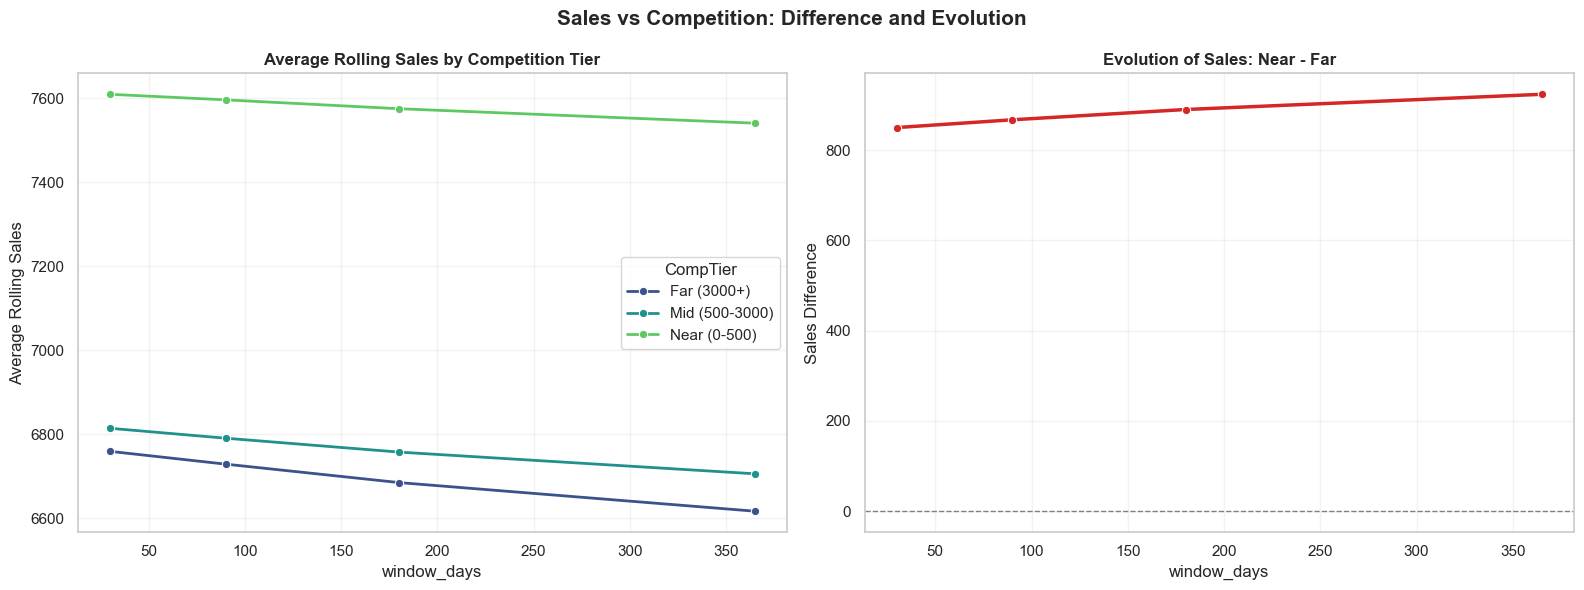

In [ ]:
# 3.9 Sales vs CompetitionDistance across window_days
window_days = [30, 90, 180, 365]

# Base frame
win_df = train_fe[['Store', 'Date', 'Sales', 'CompetitionDistance']].copy()
win_df = win_df.dropna(subset=['Date', 'Sales']).sort_values(['Store', 'Date']).reset_index(drop=True)

# Competition-distance value and tier
win_df['CompetitionDistance'] = win_df['CompetitionDistance'].fillna(win_df['CompetitionDistance'].median())
win_df['CompTier'] = pd.cut(
    win_df['CompetitionDistance'],
    bins=[-0.1, 500, 3000, np.inf],
    labels=['Near (0-500)', 'Mid (500-3000)', 'Far (3000+)']
)

# Store rolling-day averages
window_parts = []
for store_id, grp in win_df.groupby('Store', sort=False):
    g = grp.sort_values('Date').copy()
    dates = g['Date'].to_numpy()
    sales = g['Sales'].to_numpy(dtype=float)
    comp_tier = g['CompTier'].to_numpy()

    csum = np.cumsum(sales)
    cnt = np.arange(1, len(g) + 1)

    for w in window_days:
        start_dates = dates - np.timedelta64(w, 'D')
        left_idx = np.searchsorted(dates, start_dates, side='left')

        prev_sum = np.where(left_idx > 0, csum[left_idx - 1], 0.0)
        rolling_sum = csum - prev_sum
        rolling_cnt = cnt - left_idx
        rolling_avg = rolling_sum / np.where(rolling_cnt == 0, np.nan, rolling_cnt)

        window_parts.append(pd.DataFrame({
            'Store': store_id,
            'Date': dates,
            'CompTier': comp_tier,
            'window_days': w,
            'rolling_avg_sales': rolling_avg,
        }))

window_comp = pd.concat(window_parts, ignore_index=True)
window_comp = window_comp.dropna(subset=['CompTier', 'rolling_avg_sales'])

# Rolling sales by tier and window
tier_summary = (
    window_comp.groupby(['window_days', 'CompTier'], as_index=False)['rolling_avg_sales']
    .mean()
    .sort_values(['window_days', 'CompTier'])
)

# Gap summary:
near_far = tier_summary.pivot(index='window_days', columns='CompTier', values='rolling_avg_sales').reset_index()
if {'Near (0-500)', 'Far (3000+)'} <= set(near_far.columns):
    near_far['NearMinusFar'] = near_far['Near (0-500)'] - near_far['Far (3000+)']
else:
    near_far['NearMinusFar'] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Sales vs Competition: Difference and Evolution', fontsize=15, fontweight='bold')

# Comparison by competition tier across window_days
sns.lineplot(
    data=tier_summary,
    x='window_days',
    y='rolling_avg_sales',
    hue='CompTier',
    marker='o',
    linewidth=2,
    palette='viridis',
    ax=axes[0]
 )
axes[0].set_title('Average Rolling Sales by Competition Tier', fontweight='bold')
axes[0].set_xlabel('window_days')
axes[0].set_ylabel('Average Rolling Sales')

# Difference evolution (Near - Far)
sns.lineplot(
    data=near_far,
    x='window_days',
    y='NearMinusFar',
    marker='o',
    linewidth=2.5,
    color='#D62728',
    ax=axes[1]
 )
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_title('Evolution of Sales: Near - Far', fontweight='bold')
axes[1].set_xlabel('window_days')
axes[1].set_ylabel('Sales Difference')

for ax in axes:
    ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

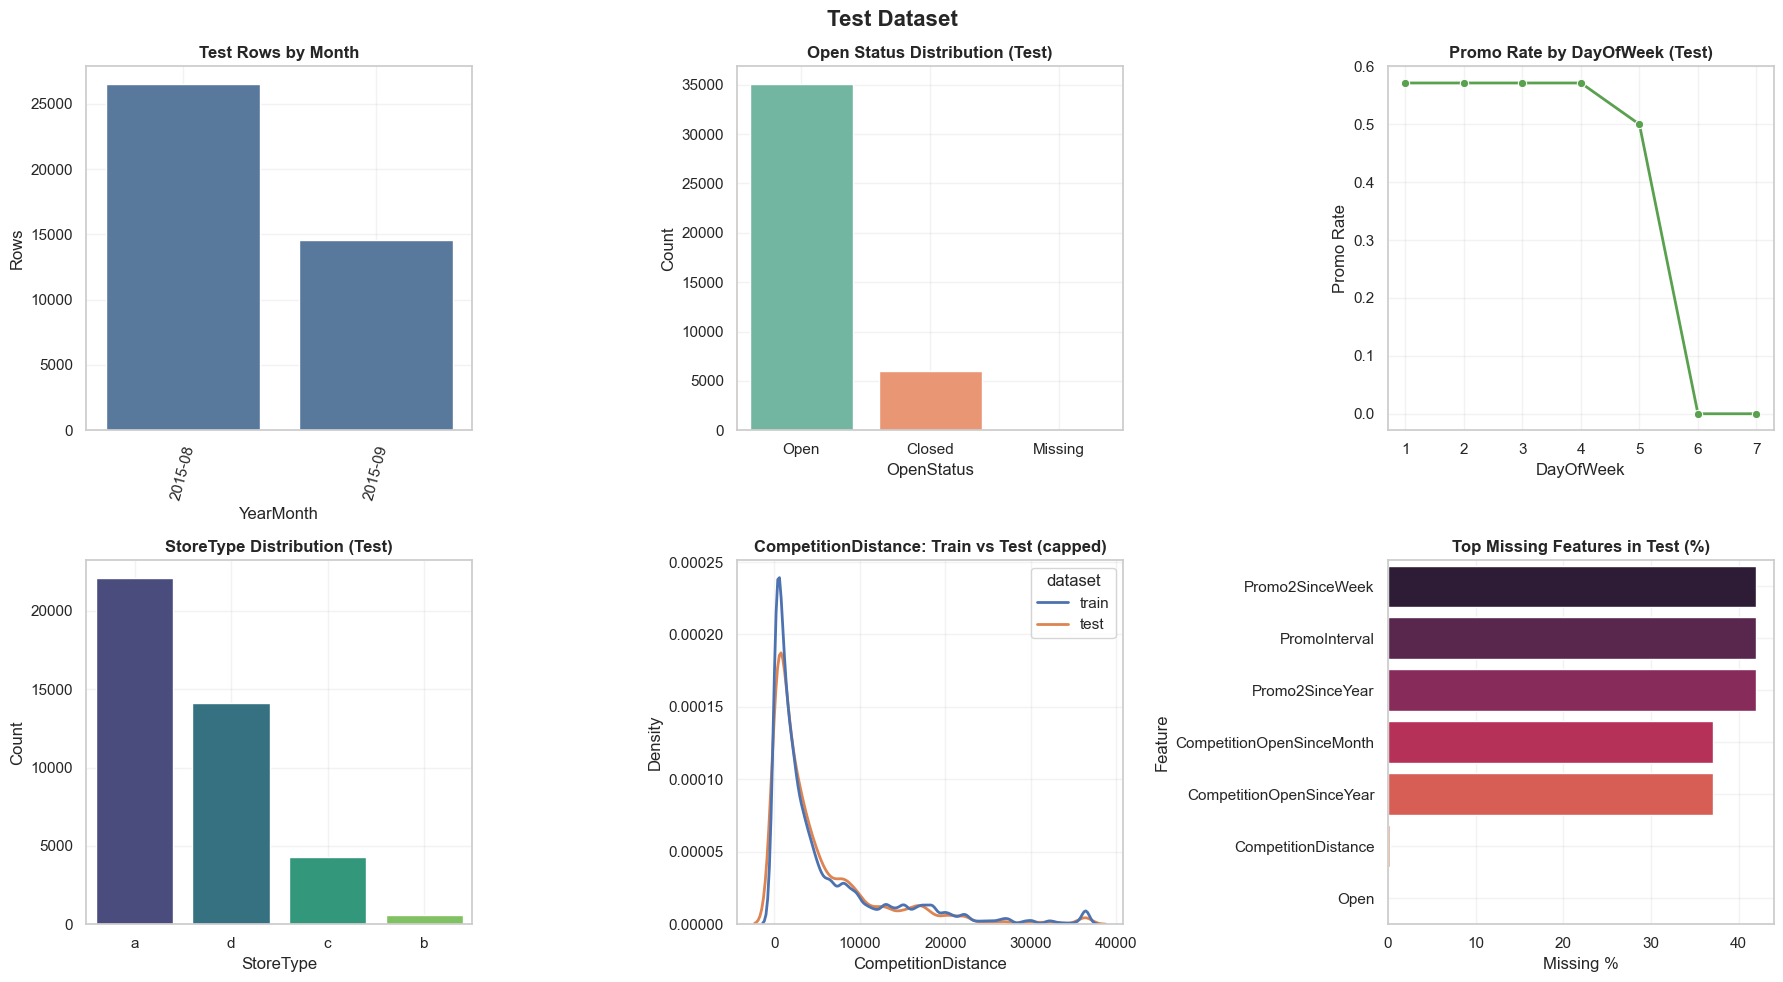

In [ ]:
# 3.10 Test-set graphs (copy)
test_vis = test_fe.copy()

# fallback if engineered test set is unavailable
if 'Date' not in test_vis.columns:
    test_vis = test_raw.merge(store, on='Store', how='left')
    test_vis['Date'] = pd.to_datetime(test_vis['Date'])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Test Dataset', fontsize=16, fontweight='bold')

# 3.10.1) volume by month
test_month_counts = (
    test_vis.assign(YearMonth=test_vis['Date'].dt.to_period('M').astype(str))
    .groupby('YearMonth', as_index=False)
    .size()
    .rename(columns={'size': 'Rows'})
)
sns.barplot(data=test_month_counts, x='YearMonth', y='Rows', color='#4C78A8', ax=axes[0, 0])
axes[0, 0].set_title('Test Rows by Month', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=75)

# 3.10.2) Open vs closed in test
if 'Open' in test_vis.columns:
    open_counts = test_vis['Open'].fillna(-1).astype(int).map({1: 'Open', 0: 'Closed', -1: 'Missing'}).value_counts().reset_index()
    open_counts.columns = ['OpenStatus', 'Count']
    sns.barplot(data=open_counts, x='OpenStatus', y='Count', palette='Set2', ax=axes[0, 1])
    axes[0, 1].set_title('Open Status Distribution (Test)', fontweight='bold')
else:
    axes[0, 1].text(0.5, 0.5, 'Open column not available', ha='center', va='center')
    axes[0, 1].set_axis_off()

# 3.10.3) Promo rate by DayOfWeek
if {'Promo', 'DayOfWeek'} <= set(test_vis.columns):
    promo_dow_test = test_vis.groupby('DayOfWeek', as_index=False)['Promo'].mean()
    sns.lineplot(data=promo_dow_test, x='DayOfWeek', y='Promo', marker='o', linewidth=2, color='#59A14F', ax=axes[0, 2])
    axes[0, 2].set_title('Promo Rate by DayOfWeek (Test)', fontweight='bold')
    axes[0, 2].set_ylabel('Promo Rate')
else:
    axes[0, 2].text(0.5, 0.5, 'Promo/DayOfWeek not available', ha='center', va='center')
    axes[0, 2].set_axis_off()

# 3.10.4) StoreType mix in test
if 'StoreType' in test_vis.columns:
    st_counts = test_vis['StoreType'].astype(str).value_counts().reset_index()
    st_counts.columns = ['StoreType', 'Count']
    sns.barplot(data=st_counts, x='StoreType', y='Count', palette='viridis', ax=axes[1, 0])
    axes[1, 0].set_title('StoreType Distribution (Test)', fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'StoreType not available', ha='center', va='center')
    axes[1, 0].set_axis_off()

# 3.10.5) CompetitionDistance: train vs test comparison
if 'CompetitionDistance' in test_vis.columns and 'CompetitionDistance' in train_fe.columns:
    comp_compare = pd.DataFrame({
        'value': pd.concat([
            train_fe['CompetitionDistance'].dropna(),
            test_vis['CompetitionDistance'].dropna()
        ], ignore_index=True),
        'dataset': (['train'] * train_fe['CompetitionDistance'].dropna().shape[0]) + (['test'] * test_vis['CompetitionDistance'].dropna().shape[0])
    })
    cap = comp_compare['value'].quantile(0.99)
    comp_compare['value_cap'] = comp_compare['value'].clip(upper=cap)
    sns.kdeplot(data=comp_compare, x='value_cap', hue='dataset', common_norm=False, linewidth=2, ax=axes[1, 1])
    axes[1, 1].set_title('CompetitionDistance: Train vs Test (capped)', fontweight='bold')
    axes[1, 1].set_xlabel('CompetitionDistance')
else:
    axes[1, 1].text(0.5, 0.5, 'CompetitionDistance unavailable', ha='center', va='center')
    axes[1, 1].set_axis_off()

# 3.10.6) Top missing columns in test
missing_test = test_vis.isna().mean().mul(100).sort_values(ascending=False).head(10)
missing_test = missing_test[missing_test > 0]
if len(missing_test) > 0:
    miss_df = missing_test.reset_index()
    miss_df.columns = ['Feature', 'MissingPct']
    sns.barplot(data=miss_df, x='MissingPct', y='Feature', palette='rocket', ax=axes[1, 2])
    axes[1, 2].set_title('Top Missing Features in Test (%)', fontweight='bold')
    axes[1, 2].set_xlabel('Missing %')
else:
    axes[1, 2].text(0.5, 0.5, 'No missing values in test columns', ha='center', va='center')
    axes[1, 2].set_axis_off()

for ax in axes.flat:
    if ax.has_data():
        ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

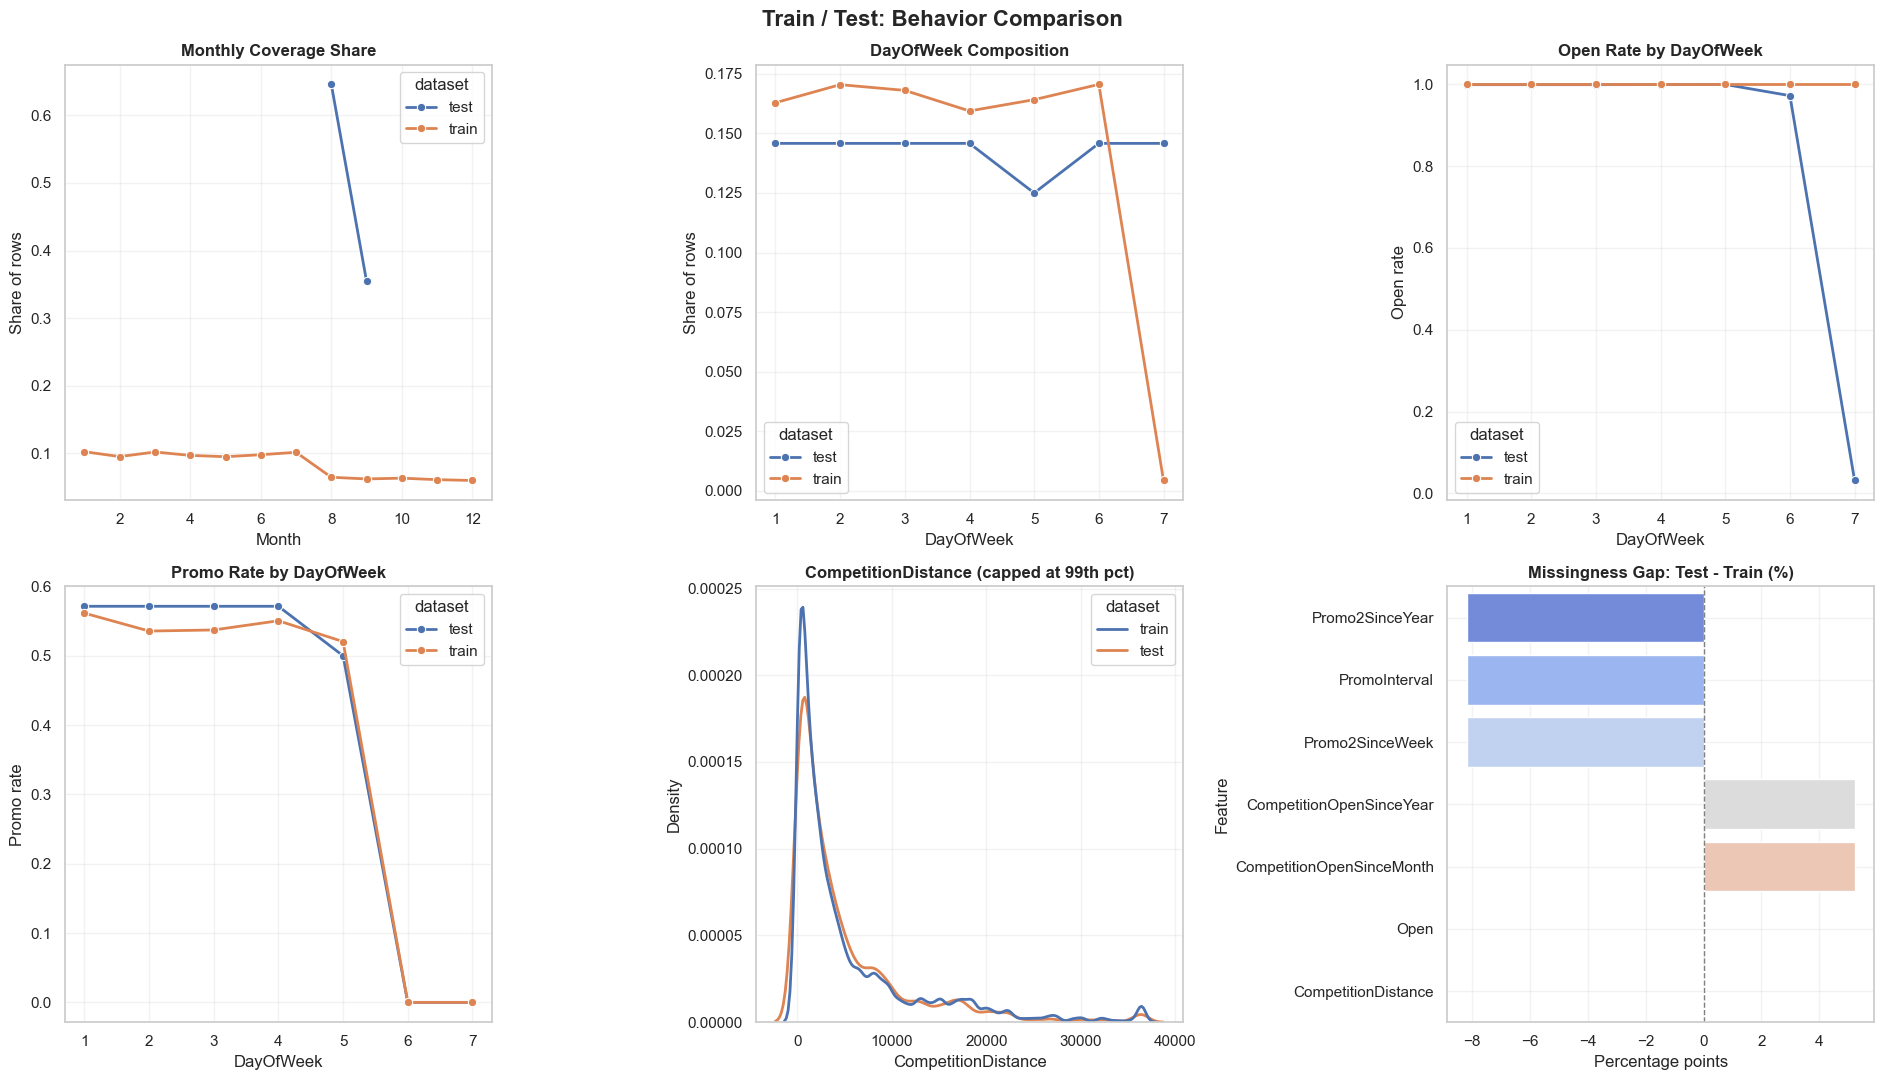

In [ ]:
# 3.11 Train vs Test comparison graphs (new copy)
train_cmp = train_fe.copy()
test_cmp = test_fe.copy()

# Keep only columns that can be compared directly
common_cols = [c for c in train_cmp.columns if c in test_cmp.columns]
train_cmp = train_cmp[common_cols].copy()
test_cmp = test_cmp[common_cols].copy()

train_cmp['dataset'] = 'train'
test_cmp['dataset'] = 'test'
cmp_df = pd.concat([train_cmp, test_cmp], ignore_index=True)

fig, axes = plt.subplots(2, 3, figsize=(19, 11))
fig.suptitle('Train / Test: Behavior Comparison', fontsize=16, fontweight='bold')

# 3.11.1) Row counts by Month (normalized)
if 'Date' in cmp_df.columns:
    monthly_share = (
        cmp_df.assign(Month=cmp_df['Date'].dt.month)
        .groupby(['dataset', 'Month'], as_index=False)
        .size()
    )
    monthly_share['Share'] = monthly_share.groupby('dataset')['size'].transform(lambda s: s / s.sum())
    sns.lineplot(data=monthly_share, x='Month', y='Share', hue='dataset', marker='o', linewidth=2, ax=axes[0, 0])
    axes[0, 0].set_title('Monthly Coverage Share', fontweight='bold')
    axes[0, 0].set_ylabel('Share of rows')
else:
    axes[0, 0].text(0.5, 0.5, 'Date not available', ha='center', va='center')
    axes[0, 0].set_axis_off()

# 3.11.2) DayOfWeek share
if 'DayOfWeek' in cmp_df.columns:
    dow_share = cmp_df.groupby(['dataset', 'DayOfWeek'], as_index=False).size()
    dow_share['Share'] = dow_share.groupby('dataset')['size'].transform(lambda s: s / s.sum())
    sns.lineplot(data=dow_share, x='DayOfWeek', y='Share', hue='dataset', marker='o', linewidth=2, ax=axes[0, 1])
    axes[0, 1].set_title('DayOfWeek Composition', fontweight='bold')
    axes[0, 1].set_ylabel('Share of rows')
else:
    axes[0, 1].text(0.5, 0.5, 'DayOfWeek not available', ha='center', va='center')
    axes[0, 1].set_axis_off()

# 3.11.3) Open rate by DayOfWeek
if {'Open', 'DayOfWeek'} <= set(cmp_df.columns):
    open_rate = cmp_df.groupby(['dataset', 'DayOfWeek'], as_index=False)['Open'].mean()
    sns.lineplot(data=open_rate, x='DayOfWeek', y='Open', hue='dataset', marker='o', linewidth=2, ax=axes[0, 2])
    axes[0, 2].set_title('Open Rate by DayOfWeek', fontweight='bold')
    axes[0, 2].set_ylabel('Open rate')
else:
    axes[0, 2].text(0.5, 0.5, 'Open/DayOfWeek not available', ha='center', va='center')
    axes[0, 2].set_axis_off()

# 3.11.4) Promo rate by DayOfWeek
if {'Promo', 'DayOfWeek'} <= set(cmp_df.columns):
    promo_rate = cmp_df.groupby(['dataset', 'DayOfWeek'], as_index=False)['Promo'].mean()
    sns.lineplot(data=promo_rate, x='DayOfWeek', y='Promo', hue='dataset', marker='o', linewidth=2, ax=axes[1, 0])
    axes[1, 0].set_title('Promo Rate by DayOfWeek', fontweight='bold')
    axes[1, 0].set_ylabel('Promo rate')
else:
    axes[1, 0].text(0.5, 0.5, 'Promo/DayOfWeek not available', ha='center', va='center')
    axes[1, 0].set_axis_off()

# 3.11.5) CompetitionDistance distribution
if 'CompetitionDistance' in cmp_df.columns:
    comp_plot = cmp_df[['dataset', 'CompetitionDistance']].dropna().copy()
    if len(comp_plot) > 0:
        cap = comp_plot['CompetitionDistance'].quantile(0.99)
        comp_plot['CompetitionDistance_cap'] = comp_plot['CompetitionDistance'].clip(upper=cap)
        sns.kdeplot(data=comp_plot, x='CompetitionDistance_cap', hue='dataset', common_norm=False, linewidth=2, ax=axes[1, 1])
        axes[1, 1].set_title('CompetitionDistance (capped at 99th pct)', fontweight='bold')
        axes[1, 1].set_xlabel('CompetitionDistance')
    else:
        axes[1, 1].text(0.5, 0.5, 'No CompetitionDistance values', ha='center', va='center')
        axes[1, 1].set_axis_off()
else:
    axes[1, 1].text(0.5, 0.5, 'CompetitionDistance not available', ha='center', va='center')
    axes[1, 1].set_axis_off()

# 3.11.6) Missingness gap (test% - train%)
train_miss = train_cmp.isna().mean() * 100
test_miss = test_cmp.isna().mean() * 100
miss_gap = (test_miss - train_miss).sort_values(key=np.abs, ascending=False).head(12)
miss_gap = miss_gap[miss_gap.abs() > 0]
if len(miss_gap) > 0:
    miss_gap_df = miss_gap.reset_index()
    miss_gap_df.columns = ['Feature', 'TestMinusTrainMissingPct']
    sns.barplot(data=miss_gap_df, x='TestMinusTrainMissingPct', y='Feature', palette='coolwarm', ax=axes[1, 2])
    axes[1, 2].axvline(0, color='gray', linestyle='--', linewidth=1)
    axes[1, 2].set_title('Missingness Gap: Test - Train (%)', fontweight='bold')
    axes[1, 2].set_xlabel('Percentage points')
else:
    axes[1, 2].text(0.5, 0.5, 'No missingness differences', ha='center', va='center')
    axes[1, 2].set_axis_off()

for ax in axes.flat:
    if ax.has_data():
        ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()

## 4) Model Preparation

In [63]:
# 4.1 Define prediction target
target = 'Sales'

# 4.2 Build base training and test matrices
drop_cols = ['Sales', 'Customers', 'Date']
X = train_fe.drop(columns=[c for c in drop_cols if c in train_fe.columns])
y = np.log1p(train_fe[target].astype(float))
X_submit = test_fe.drop(columns=['Date'])

# 4.3 Time-based split (last 6 weeks for validation)
cutoff = train_fe['Date'].max() - pd.Timedelta(weeks=6)
train_idx = train_fe['Date'] < cutoff
valid_idx = train_fe['Date'] >= cutoff

X_train = X.loc[train_idx].copy()
y_train = y.loc[train_idx].copy()
X_test = X.loc[valid_idx].copy()
y_test = y.loc[valid_idx].copy()

# 4.4 Identify categorical vs numeric features
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
categorical_cols = [c for c in categorical_cols if c in X_train.columns]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

# 4.5 Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median'))]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]), categorical_cols),
    ],
    remainder='drop'
)

# 4.6 Split check shape
print('Train split:', X_train.shape)
print('Test split :', X_test.shape)

Train split: (802942, 26)
Test split : (41396, 26)


## 5) Model Training and Validation

In [ ]:
# 5.1 RMSPE metric for Rossmann evaluation
def rmspe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# 5.2 Choose model (XGBoost preferred, fallback to RandomForest)
try:
    from xgboost import XGBRegressor
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
    )
    model_name = 'XGBRegressor'
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )
    model_name = 'RandomForestRegressor (fallback)'

# 5.3 Full training pipeline (preprocess + model)
pipe = Pipeline([
    ('prep', preprocessor),
    ('model', model),
])

# 5.4 Train on training split
pipe.fit(X_train, y_train)

# 5.5 Predict on train and test splits
train_pred_log = pipe.predict(X_train)
test_pred_log_eval = pipe.predict(X_test)

train_pred = np.expm1(train_pred_log)
test_pred_eval = np.expm1(test_pred_log_eval)

y_train_true = np.expm1(y_train)
y_test_true = np.expm1(y_test)

# 5.6 Train-set metrics (accuracy proxy + errors)
train_r2 = r2_score(y_train_true, train_pred)
train_rmspe = rmspe(y_train_true, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_true, train_pred))
train_mae = mean_absolute_error(y_train_true, train_pred)

# 5.7 Test metrics
test_r2 = r2_score(y_test_true, test_pred_eval)
test_rmspe = rmspe(y_test_true, test_pred_eval)
test_rmse = np.sqrt(mean_squared_error(y_test_true, test_pred_eval))
test_mae = mean_absolute_error(y_test_true, test_pred_eval)

# 5.8 Report metrics
print('Model:', model_name)
print('\nTrain metrics:')
print(f'  R² (accuracy proxy): {train_r2:.5f}')
print(f'  RMSPE             : {train_rmspe:.5f}')
print(f'  RMSE              : {train_rmse:,.2f}')
print(f'  MAE               : {train_mae:,.2f}')

print('\nTest metrics:')
print(f'  R² (accuracy proxy): {test_r2:.5f}')
print(f'  RMSPE             : {test_rmspe:.5f}')
print(f'  RMSE              : {test_rmse:,.2f}')
print(f'  MAE               : {test_mae:,.2f}')

Model: XGBRegressor

Train metrics:
  R² (accuracy proxy): 0.93030
  RMSPE             : 0.16761
  RMSE              : 820.24
  MAE               : 566.26

Validation metrics:
  R² (accuracy proxy): 0.89458
  RMSPE             : 0.14551
  RMSE              : 988.35
  MAE               : 688.58


## 6) Final Training and Submission File

In [ ]:
# 6.1 Refit on all available training data
pipe.fit(X, y)

# 6.2 Predict submission set in log-space then convert back
test_pred_log = pipe.predict(X_submit)
test_pred = np.expm1(test_pred_log)

# 6.3 Competition rule: closed stores => zero predicted sales
if 'Open' in test_fe.columns:
    test_pred = np.where(test_fe['Open'].fillna(1).values == 0, 0, test_pred)

# 6.4 Build submission file
submission = pd.DataFrame({
    'Id': test_raw['Id'],
    'Sales': test_pred,
})

# 6.5 Save submission to disk
output_path = DATA_DIR / 'submission.csv'
submission.to_csv(output_path, index=False)

# 6.6 Preview output
print(f'Submission saved to: {output_path}')
display(submission.head())

Submission saved to: C:\bootcamp\Rossman_finalproject\Datasets\submission.csv


,Id,Sales
0,1,4703.756836
1,2,7364.856445
2,3,9693.145508
3,4,6707.486328
4,5,7411.803711
